In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from networks import fcn

In [10]:
data = np.load(r'E:\Heat_diffusion_laser_metadata\30_Sep_2025_06_30_29_FBH13mm_step_size_sim_step_0_002m_p1.npz', allow_pickle=True)
data = np.array(data['data'], dtype=np.float32)

In [11]:
data.shape

(409, 240, 320)

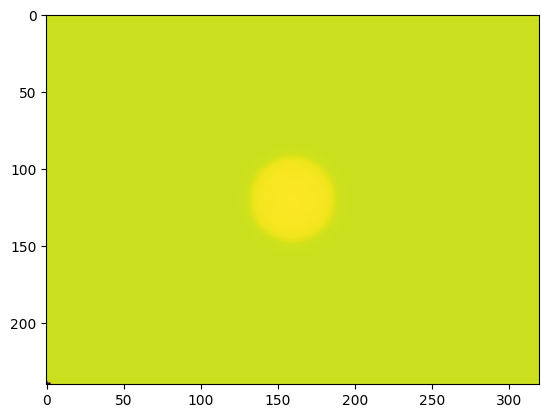

In [4]:
plt.imshow(data[10,:,:])

In [5]:
layers_temp = np.array([3,30,30,30,30,30,30,30,30,1]) #8 hidden layers
layer_lap=np.array([3,20,20,1])

PINN=fcn(layers_temp,layer_lap)

In [6]:
print(PINN)

fcn(
  (loss_function): MSELoss()
  (linears_temp): ModuleList(
    (0): Linear(in_features=3, out_features=30, bias=True)
    (1-7): 7 x Linear(in_features=30, out_features=30, bias=True)
    (8): Linear(in_features=30, out_features=1, bias=True)
  )
  (linears_lap): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [12]:
t,y,x=data.shape
y_center=y//2
x_center=x//2

spread=50

data=data[10:,y_center-spread:y_center+spread,x_center-spread:x_center+spread]

In [13]:
data.shape

(399, 100, 100)

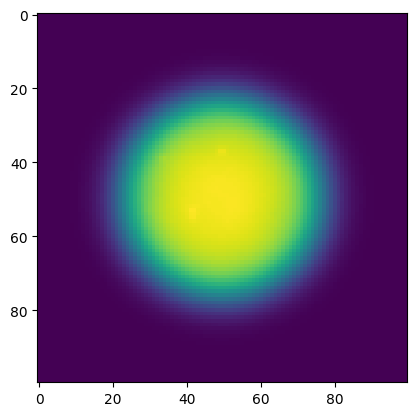

In [15]:
plt.imshow(data[10])

In [23]:
Nt,Ny,Nx=data.shape

t = torch.linspace(0, 1, Nt)
x = torch.linspace(0, 1, Nx)
y = torch.linspace(0, 1, Ny)

tt, yy, xx = torch.meshgrid(t, y, x, indexing='ij')

coords = torch.stack([tt, yy,xx], dim=-1)  # shape (399, 100, 100, 3)
coords = coords.reshape(-1, 3)              # shape (399*100*100, 3)

values = data.reshape(-1, 1)                   # shape (399*100*100, 1)
values=torch.from_numpy(values)

In [27]:
idx = torch.randperm(coords.shape[0])[:100000]

In [28]:
idx

tensor([ 911612,  867112, 1869069,  ...,  598389, 1425153, 2556584])